In [1]:
import keras
keras.__version__

'2.4.3'

In [2]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from google.colab import drive
#import gdown
plt.style.use("seaborn")


In [3]:
"""
!gdown --id '1EUZSeZa6HqkIMCU33VFeb2Nwn6e6KQua' --output food-11.zip # 下載資料集
!unzip food-11.zip # 解壓縮
"""

"\n!gdown --id '1EUZSeZa6HqkIMCU33VFeb2Nwn6e6KQua' --output food-11.zip # 下載資料集\n!unzip food-11.zip # 解壓縮\n"

In [4]:
base_dir = './food_data'
os.mkdir(base_dir)
testing_dir = os.path.join(base_dir,'testing')
training_dir = os.path.join(base_dir,'training')
validation_dir = os.path.join(base_dir,'validation')

categorical_name=['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles_Pasta', 
         'Rice', 'Seafood', 'Soup', 'Vegetable_Fruit']

folder=[testing_dir,training_dir,validation_dir]

for i in range(len(folder)):
  os.mkdir(folder[i])
  for j in range(len(categorical_name)):
    forder_path = os.path.join(folder[i], categorical_name[j])
    os.mkdir(forder_path)

In [5]:
def copyfile(path_from, path_to, categorical_name):
    image_dir = sorted(os.listdir(path_from))
    for i, file in enumerate(image_dir):
      Path_from = os.path.join(path_from, file)
      Path_to = os.path.join(path_to, categorical_name[int(file.split("_")[0])])
      shutil.copyfile(Path_from, os.path.join(Path_to,file))
    
        
    
       

In [6]:
def readfile(path,is_test):
  image_dir = sorted(os.listdir(path))
  x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
  y = np.zeros((len(image_dir),11), dtype=np.uint8)
  if is_test==False:
    for i, file in enumerate(image_dir):
      img = cv2.imread(os.path.join(path, file))
      x[i, :, :] = cv2.resize(img,(128, 128))
      y[i,int(file.split("_")[0])] = 1
    
    return x, y
  else:
    for i, file in enumerate(image_dir):
      img = cv2.imread(os.path.join(path, file))
      x[i, :, :] = cv2.resize(img,(128, 128))
            
    return x

In [7]:
#採DataGenerator(flow_from_directory)的形式，其需要相同類別全部放入相同資料夾
from_dir = './food-11'
to_dir = './food_data'
copyfile(os.path.join(from_dir,'training'),os.path.join(to_dir,'training'),categorical_name)

In [8]:
#可以看到training data內各個類別間數量分配不是那麼平均，或許可以考慮做confusion matrix
copyfile(os.path.join(from_dir,'validation'),os.path.join(to_dir,'validation'),categorical_name)
food_data_dir = sorted(os.listdir(os.path.join(to_dir,'training')))
for i, file in enumerate(food_data_dir):
  print(file,':',len(os.listdir(os.path.join('./food_data/training',file))))

Bread : 994
Dairy product : 429
Dessert : 1500
Egg : 986
Fried food : 848
Meat : 1325
Noodles_Pasta : 440
Rice : 280
Seafood : 855
Soup : 1500
Vegetable_Fruit : 709


In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        # This is the target directory
        './food_data/training',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        './food_data/validation',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [10]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 128, 128, 3)
labels batch shape: (20, 11)


In [11]:
from keras import layers
from keras import models

model=models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(11, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [12]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
       optimizer=optimizers.RMSprop(lr=1e-4),
       metrics=['acc'])

In [13]:
history = model.fit_generator(
      train_generator,
      #總共9866，每批20
      steps_per_epoch=493,
      epochs=30,
      validation_data=validation_generator,
      #總共3430，每批20
      validation_steps=171)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
493/493 [==============================] - 266s 539ms/step - loss: 2.0605 - acc: 0.2740 - val_loss: 1.8860 - val_acc: 0.3243
Epoch 2/30
493/493 [==============================] - 246s 499ms/step - loss: 1.7952 - acc: 0.3748 - val_loss: 1.7339 - val_acc: 0.3927
Epoch 3/30
493/493 [==============================] - 247s 501ms/step - loss: 1.6543 - acc: 0.4276 - val_loss: 1.7943 - val_acc: 0.3901
Epoch 4/30
493/493 [==============================] - 246s 499ms/step - loss: 1.5420 - acc: 0.4677 - val_loss: 1.6666 - val_acc: 0.4251
Epoch 5/30
493/493 [==============================] - 247s 502ms/step - loss: 1.4427 - acc: 0.5056 - val_loss: 1.5868 - val_acc: 0.4550
Epoch 6/30
493/493 [==============================] - 246s 499ms/step - loss: 1.3504 - acc: 0.5337 - val_loss: 1.5435 - val_acc: 0.4766
Epoch 7/30
493/493 [==============================] - 232s 470ms/step - loss: 1.2682 - acc: 0.5663 - val_los

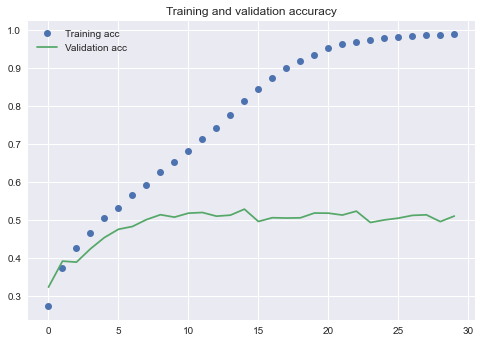

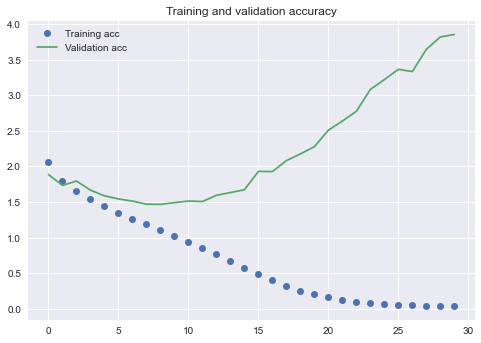

In [14]:
#training data之準確率接近99%，但validation卻只有50%，懷疑有overfitting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


def plot_loss(train_loss,val_loss,title):
  epochs = range(len(train_loss))
  plt.plot(epochs, train_loss, 'o', label='Training acc')
  plt.plot(epochs, val_loss, '-', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()



plot_loss(acc,val_acc,'Training and validation accuracy')
plot_loss(loss,val_loss,'Training and validation loss')


In [15]:
#由drive提取資料實在太慢，改採ImageDataGenerator(flow)的形式
train_x,train_y = readfile('./food-11/training',False)
val_x,val_y = readfile('./food-11/validation',False)
test_x = readfile('./food-11/testing',True)
print(train_x.shape,train_y.shape)
print(val_x.shape,val_y.shape)
print(test_x.shape)

(9866, 128, 128, 3) (9866, 11)
(3430, 128, 128, 3) (3430, 11)
(3347, 128, 128, 3)


In [16]:
#做data augmentation，L2 regularization，drop_out避免overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator = train_datagen.flow(train_x,train_y,batch_size=20)

validation_generator = ImageDataGenerator(rescale=1./255).flow(val_x,val_y,batch_size=20)

In [17]:
from keras import regularizers

model=models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy',
       optimizer=optimizers.Adam(lr=1e-3),
       metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)      

In [18]:
history = model.fit_generator(
      train_generator,
      #總共9866，每批20
      steps_per_epoch=493,
      epochs=100,
      validation_data=validation_generator,
      #總共3430，每批20
      validation_steps=171)

Epoch 1/100
493/493 [==============================] - 249s 505ms/step - loss: 2.3670 - acc: 0.1884 - val_loss: 2.1807 - val_acc: 0.2357
Epoch 2/100
493/493 [==============================] - 255s 518ms/step - loss: 2.1201 - acc: 0.2716 - val_loss: 1.9504 - val_acc: 0.3251
Epoch 3/100
493/493 [==============================] - 252s 512ms/step - loss: 2.0329 - acc: 0.3048 - val_loss: 1.9410 - val_acc: 0.3389
Epoch 4/100
493/493 [==============================] - 250s 507ms/step - loss: 1.9741 - acc: 0.3343 - val_loss: 1.9022 - val_acc: 0.3635
Epoch 5/100
493/493 [==============================] - 248s 502ms/step - loss: 1.9167 - acc: 0.3678 - val_loss: 1.7588 - val_acc: 0.4199
Epoch 6/100
493/493 [==============================] - 252s 511ms/step - loss: 1.8624 - acc: 0.3880 - val_loss: 1.7109 - val_acc: 0.4474
Epoch 7/100
493/493 [==============================] - 243s 493ms/step - loss: 1.7835 - acc: 0.4144 - val_loss: 1.6654 - val_acc: 0.4643
Epoch 8/100
493/493 [====================

493/493 [==============================] - 206s 418ms/step - loss: 1.0823 - acc: 0.6767 - val_loss: 1.1227 - val_acc: 0.6754
Epoch 61/100
493/493 [==============================] - 207s 420ms/step - loss: 1.0874 - acc: 0.6797 - val_loss: 1.1846 - val_acc: 0.6553
Epoch 62/100
493/493 [==============================] - 207s 420ms/step - loss: 1.1008 - acc: 0.6697 - val_loss: 1.1673 - val_acc: 0.6667
Epoch 63/100
493/493 [==============================] - 206s 418ms/step - loss: 1.0798 - acc: 0.6750 - val_loss: 1.1830 - val_acc: 0.6518
Epoch 64/100
493/493 [==============================] - 206s 418ms/step - loss: 1.0581 - acc: 0.6838 - val_loss: 1.0964 - val_acc: 0.6898
Epoch 65/100
493/493 [==============================] - 206s 418ms/step - loss: 1.0506 - acc: 0.6882 - val_loss: 1.1869 - val_acc: 0.6711
Epoch 66/100
493/493 [==============================] - 206s 418ms/step - loss: 1.0755 - acc: 0.6788 - val_loss: 1.1389 - val_acc: 0.6708
Epoch 67/100
493/493 [=========================

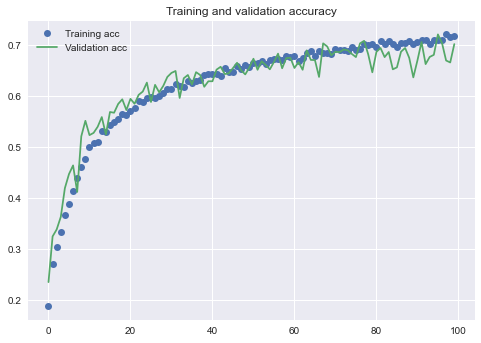

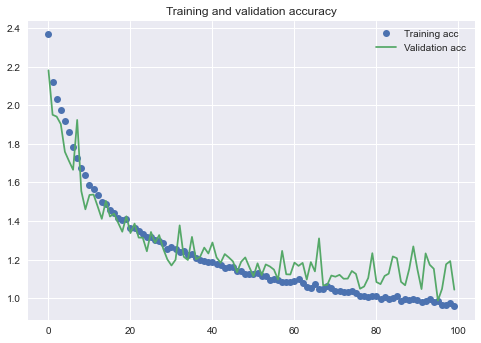

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


plot_loss(acc,val_acc,'Training and validation accuracy')
plot_loss(loss,val_loss,'Training and validation loss')

In [25]:
#結果看起來不在overfitting了，並且從原本的validation50%準確率到現在有近70%。
#接下來是要將training和validation和在一起在做一次訓練，epoch=70應該就足夠了
total_train_x=np.concatenate((train_x, val_x), axis=0)
total_train_y=np.concatenate((train_y, val_y), axis=0)
print(total_train_x.shape,total_train_y.shape)
total_train_generator = train_datagen.flow(total_train_x,total_train_y,batch_size=20)

(13296, 128, 128, 3) (13296, 11)


In [26]:
history = model.fit_generator(
      total_train_generator,
      #總共9866，每批20
      steps_per_epoch=664,
      epochs=90)

Epoch 1/90
664/664 [==============================] - 323s 486ms/step - loss: 1.0215 - acc: 0.7001
Epoch 2/90
664/664 [==============================] - 328s 494ms/step - loss: 1.0059 - acc: 0.7044
Epoch 3/90
664/664 [==============================] - 325s 490ms/step - loss: 1.0099 - acc: 0.6971
Epoch 4/90
664/664 [==============================] - 312s 469ms/step - loss: 0.9907 - acc: 0.7053
Epoch 5/90
664/664 [==============================] - 302s 455ms/step - loss: 0.9999 - acc: 0.7081
Epoch 6/90
664/664 [==============================] - 302s 454ms/step - loss: 0.9862 - acc: 0.7090
Epoch 7/90
664/664 [==============================] - 302s 455ms/step - loss: 0.9935 - acc: 0.7088
Epoch 8/90
664/664 [==============================] - 303s 456ms/step - loss: 0.9853 - acc: 0.7106
Epoch 9/90
664/664 [==============================] - 303s 456ms/step - loss: 0.9842 - acc: 0.7115
Epoch 10/90
664/664 [==============================] - 302s 454ms/step - loss: 0.9833 - acc: 0.7137
Epoch 11/

KeyboardInterrupt: 